In [ ]:
import os
import json
import torch
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import zipfile
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

In [ ]:
# Unzip the dataset
zip_path = './TestDataSet.zip'
extract_dir = './TestDataSet'

if not os.path.exists(extract_dir):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)

# Confirm folder structure
print("Extracted files:", os.listdir(extract_dir))

Extracted files: ['TestDataSet', '__MACOSX']


In [ ]:
# === Setup ===
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

mean_norms = [0.485, 0.456, 0.406]
std_norms = [0.229, 0.224, 0.225]
plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_norms, std=std_norms)
])

# === Load Dataset ===
dataset_path = './TestDataSet/TestDataSet'
dataset = ImageFolder(root=dataset_path, transform=plain_transforms)
loader = DataLoader(dataset, batch_size=32, shuffle=False)

# === Load labels_list.json and build label map ===
with open(os.path.join(dataset_path, 'labels_list.json')) as f:
    class_names = json.load(f)

folder_to_imagenet_idx = {
    folder_name: int(label.split(":")[0].strip('"'))
    for folder_name, label in zip(dataset.classes, class_names)
}

imagenet_label_map = {
    i: folder_to_imagenet_idx[folder]
    for i, folder in enumerate(dataset.classes)
}

# === Load Pretrained ResNet-34 ===
model = torchvision.models.resnet34(weights='IMAGENET1K_V1').to(device)
model.eval()

# === Evaluation Function ===
def evaluate(model, loader, already_imagenet_labels=False):
    top1, top5, total = 0, 0, 0
    with torch.no_grad():
        for imgs, labels in tqdm(loader):
            imgs, labels = imgs.to(device), labels.to(device)

            # Convert to ImageNet class indices if needed
            if not already_imagenet_labels:
                labels = torch.tensor([imagenet_label_map[label.item()] for label in labels]).to(device)

            outputs = model(imgs)
            _, pred1 = outputs.topk(1, dim=1)
            _, pred5 = outputs.topk(5, dim=1)

            top1 += (pred1.squeeze() == labels).sum().item()
            top5 += sum([labels[i] in pred5[i] for i in range(len(labels))])
            total += labels.size(0)

    print(f"Top-1 Accuracy: {top1 / total:.4f}")
    print(f"Top-5 Accuracy: {top5 / total:.4f}")
    return top1 / total, top5 / total

# === Task 1: Baseline Evaluation ===
print("\n✅ Task 1: Baseline Evaluation")
baseline_top1, baseline_top5 = evaluate(model, loader)


✅ Task 1: Baseline Evaluation


100%|██████████| 16/16 [00:01<00:00, 10.31it/s]

Top-1 Accuracy: 0.7600
Top-5 Accuracy: 0.9420


In [ ]:
# === Task 2: FGSM Attack ===
def fgsm_attack(img, label, model, epsilon):
    img.requires_grad = True
    output = model(img)
    loss = nn.CrossEntropyLoss()(output, label)
    model.zero_grad()
    loss.backward()
    adv_img = img + epsilon * img.grad.sign()
    adv_img = torch.clamp(adv_img, 0, 1)
    return adv_img.detach()

epsilon = 0.02
adv_dir = './Adversarial_Test_Set_1'
os.makedirs(adv_dir, exist_ok=True)
adv_imgs, adv_labels = [], []

print("\n⚔️ Task 2: Generating FGSM Adversarial Images...")
for imgs, labels in tqdm(loader):
    imgs, labels = imgs.to(device), labels.to(device)
    for j in range(len(imgs)):
        imagenet_label = torch.tensor([imagenet_label_map[labels[j].item()]]).to(device)
        img = imgs[j].unsqueeze(0)
        adv_img = fgsm_attack(img, imagenet_label, model, epsilon)
        adv_imgs.append(adv_img.squeeze().cpu())
        adv_labels.append(imagenet_label.item())

torch.save((adv_imgs, adv_labels), os.path.join(adv_dir, 'fgsm_data.pt'))

# === FGSM Evaluation ===
print("\n🧪 Evaluating FGSM Adversarial Set")
fgsm_dataset = torch.utils.data.TensorDataset(torch.stack(adv_imgs), torch.tensor(adv_labels))
fgsm_loader = DataLoader(fgsm_dataset, batch_size=32)
evaluate(model, fgsm_loader, already_imagenet_labels=True)


⚔️ Task 2: Generating FGSM Adversarial Images...


100%|██████████| 16/16 [00:08<00:00,  1.95it/s]



🧪 Evaluating FGSM Adversarial Set


100%|██████████| 16/16 [00:00<00:00, 17.26it/s]

Top-1 Accuracy: 0.2640
Top-5 Accuracy: 0.5060


(0.264, 0.506)

In [17]:
# === Task 3: Iterative Attack ===
def iterative_attack(img, label, model, epsilon=0.02, alpha=0.002, steps=5):
    ori_img = img.clone().detach()
    for _ in range(steps):
        img.requires_grad = True
        output = model(img)
        loss = nn.CrossEntropyLoss()(output, label)
        model.zero_grad()
        loss.backward()
        grad = img.grad.data
        img = img + alpha * grad.sign()
        eta = torch.clamp(img - ori_img, min=-epsilon, max=epsilon)
        img = torch.clamp(ori_img + eta, 0, 1).detach()
    return img

adv_dir2 = './Adversarial_Test_Set_2'
os.makedirs(adv_dir2, exist_ok=True)
adv_imgs2, adv_labels2 = [], []

print("\n⚔️ Task 3: Generating Iterative Adversarial Images...")
for imgs, labels in tqdm(loader):
    imgs, labels = imgs.to(device), labels.to(device)
    for j in range(len(imgs)):
        imagenet_label = torch.tensor([imagenet_label_map[labels[j].item()]]).to(device)
        img = imgs[j].unsqueeze(0)
        adv_img = iterative_attack(img, imagenet_label, model)
        adv_imgs2.append(adv_img.squeeze().cpu())
        adv_labels2.append(imagenet_label.item())

torch.save((adv_imgs2, adv_labels2), os.path.join(adv_dir2, 'iterative_data.pt'))

# === Iterative Evaluation ===
print("\n🧪 Evaluating Iterative Attack Set")
iter_dataset = torch.utils.data.TensorDataset(torch.stack(adv_imgs2), torch.tensor(adv_labels2))
iter_loader = DataLoader(iter_dataset, batch_size=32)
evaluate(model, iter_loader, already_imagenet_labels=True)



⚔️ Task 3: Generating Iterative Adversarial Images...


100%|██████████| 16/16 [00:36<00:00,  2.26s/it]



🧪 Evaluating Iterative Attack Set


100%|██████████| 16/16 [00:00<00:00, 18.48it/s]

Top-1 Accuracy: 0.0600
Top-5 Accuracy: 0.2360


(0.06, 0.236)

In [18]:
import random

# === Task 4: Patch Attack (32x32 region only) ===
def patch_attack(img, label, model, patch_size=32, epsilon=0.5, alpha=0.01, steps=5):
    img = img.clone().detach()
    ori_img = img.clone()

    _, _, H, W = img.shape
    x = random.randint(0, W - patch_size)
    y = random.randint(0, H - patch_size)

    for _ in range(steps):
        img.requires_grad = True
        output = model(img)
        loss = nn.CrossEntropyLoss()(output, label)
        model.zero_grad()
        loss.backward()
        grad = img.grad.data

        # Apply gradient sign only in patch
        patch_grad = grad[:, :, y:y+patch_size, x:x+patch_size].sign()
        img.data[:, :, y:y+patch_size, x:x+patch_size] += alpha * patch_grad

        # Clip patch to allowed epsilon region
        patch_delta = img.data - ori_img
        patch_delta = torch.clamp(patch_delta, min=-epsilon, max=epsilon)
        img.data = torch.clamp(ori_img + patch_delta, 0, 1)

    return img.detach()

# === Generate Adversarial Patch Set ===
adv_dir3 = './Adversarial_Test_Set_3'
os.makedirs(adv_dir3, exist_ok=True)
adv_imgs3, adv_labels3 = [], []

print("\n⚔️ Task 4: Generating Patch Adversarial Images...")
for imgs, labels in tqdm(loader):
    imgs, labels = imgs.to(device), labels.to(device)
    for j in range(len(imgs)):
        label_imagenet = torch.tensor([imagenet_label_map[labels[j].item()]]).to(device)
        img = imgs[j].unsqueeze(0)
        adv_img = patch_attack(img, label_imagenet, model, epsilon=0.5, alpha=0.01, steps=5)
        adv_imgs3.append(adv_img.squeeze().cpu())
        adv_labels3.append(label_imagenet.item())

torch.save((adv_imgs3, adv_labels3), os.path.join(adv_dir3, 'patch_data.pt'))

# === Evaluate Patch Adversarial Set ===
print("\n🧪 Evaluating Patch Attack Set")
patch_dataset = torch.utils.data.TensorDataset(torch.stack(adv_imgs3), torch.tensor(adv_labels3))
patch_loader = DataLoader(patch_dataset, batch_size=32)
evaluate(model, patch_loader, already_imagenet_labels=True)



⚔️ Task 4: Generating Patch Adversarial Images...


100%|██████████| 16/16 [00:37<00:00,  2.36s/it]



🧪 Evaluating Patch Attack Set


100%|██████████| 16/16 [00:00<00:00, 18.32it/s]

Top-1 Accuracy: 0.3320
Top-5 Accuracy: 0.5440


(0.332, 0.544)

In [19]:
# === Task 5: Transferability Evaluation ===
print("\n🔄 Task 5: Evaluating Transferability on DenseNet121")
transfer_model = torchvision.models.densenet121(weights='IMAGENET1K_V1').to(device)
transfer_model.eval()

# Reuse previously saved datasets
print("✅ Original Clean Set on DenseNet:")
evaluate(transfer_model, loader)  # Clean data: dataset labels are 0–99 → will be mapped

print("\n✅ FGSM Set on DenseNet:")
evaluate(transfer_model, fgsm_loader, already_imagenet_labels=True)

print("\n✅ Iterative Set on DenseNet:")
evaluate(transfer_model, iter_loader, already_imagenet_labels=True)

print("\n✅ Patch Set on DenseNet:")
evaluate(transfer_model, patch_loader, already_imagenet_labels=True)



🔄 Task 5: Evaluating Transferability on DenseNet121


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 115MB/s]


✅ Original Clean Set on DenseNet:


100%|██████████| 16/16 [00:02<00:00,  6.19it/s]


Top-1 Accuracy: 0.7480
Top-5 Accuracy: 0.9360

✅ FGSM Set on DenseNet:


100%|██████████| 16/16 [00:01<00:00,  9.77it/s]


Top-1 Accuracy: 0.4240
Top-5 Accuracy: 0.6640

✅ Iterative Set on DenseNet:


100%|██████████| 16/16 [00:01<00:00,  9.72it/s]


Top-1 Accuracy: 0.4160
Top-5 Accuracy: 0.6600

✅ Patch Set on DenseNet:


100%|██████████| 16/16 [00:01<00:00,  9.62it/s]

Top-1 Accuracy: 0.4560
Top-5 Accuracy: 0.6840


(0.456, 0.684)

In [20]:
import matplotlib.pyplot as plt

# === Denormalize helper ===
def denormalize(img):
    mean = torch.tensor(mean_norms).view(3, 1, 1)
    std = torch.tensor(std_norms).view(3, 1, 1)
    return torch.clamp(img * std + mean, 0, 1)

# === Single prediction label ===
def get_top1_label(img_tensor, model):
    with torch.no_grad():
        output = model(img_tensor.unsqueeze(0).to(device))
        return output.argmax(dim=1).item()

# === Visualization function ===
def visualize_examples(original_imgs, adversarial_imgs, title):
    fig, axes = plt.subplots(len(original_imgs), 3, figsize=(10, 3 * len(original_imgs)))
    if len(original_imgs) == 1:
        axes = [axes]

    for i in range(len(original_imgs)):
        orig = denormalize(original_imgs[i])
        adv = denormalize(adversarial_imgs[i])
        diff = torch.abs(adv - orig)

        orig_pred = get_top1_label(original_imgs[i], model)
        adv_pred = get_top1_label(adversarial_imgs[i], model)

        axes[i][0].imshow(orig.permute(1, 2, 0).cpu().numpy())
        axes[i][0].set_title(f"Original (Pred: {orig_pred})")
        axes[i][1].imshow(adv.permute(1, 2, 0).cpu().numpy())
        axes[i][1].set_title(f"Adversarial (Pred: {adv_pred})")
        axes[i][2].imshow(diff.permute(1, 2, 0).cpu().numpy())
        axes[i][2].set_title("Perturbation")

        for ax in axes[i]:
            ax.axis('off')

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()


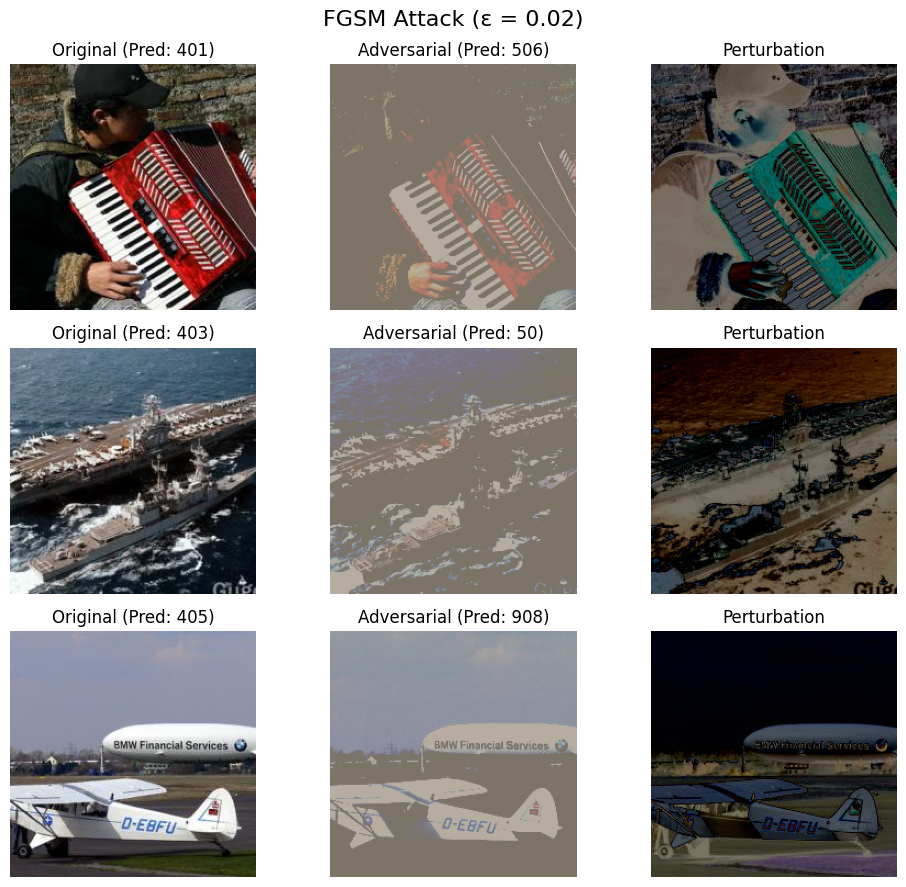

In [21]:
sample_ids = [0, 10, 20]
original_samples = [dataset[i][0].cpu() for i in sample_ids]
fgsm_samples = [adv_imgs[i] for i in sample_ids]

visualize_examples(original_samples, fgsm_samples, "FGSM Attack (ε = 0.02)")


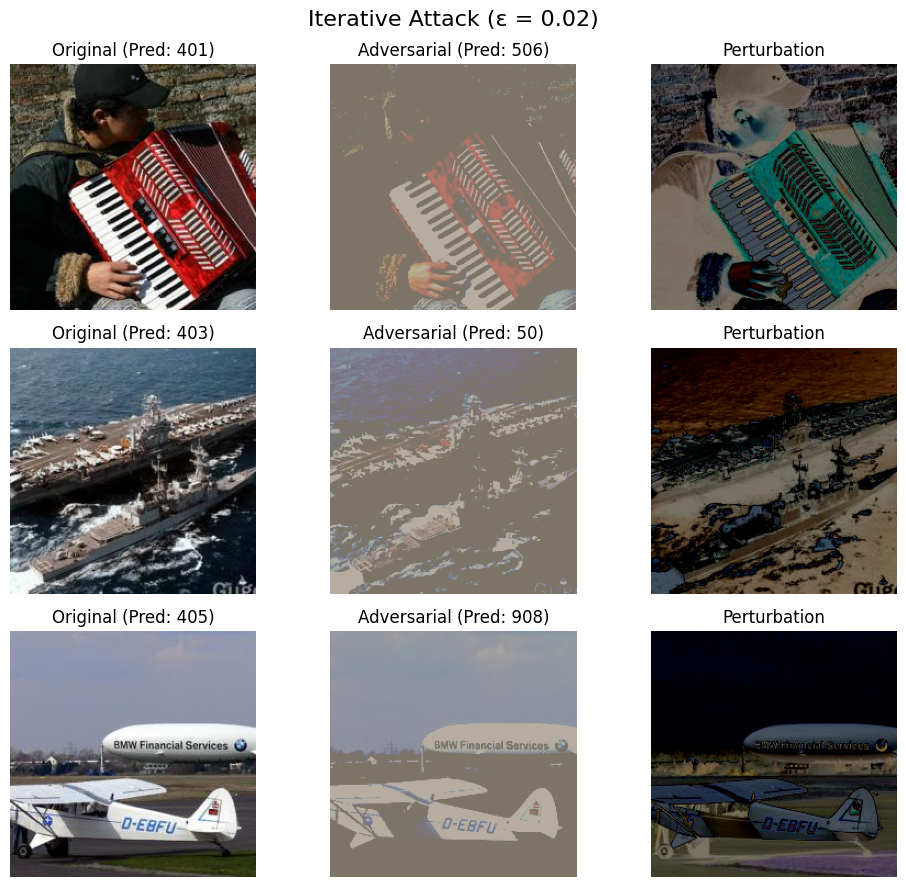

In [22]:
iter_samples = [adv_imgs2[i] for i in sample_ids]
visualize_examples(original_samples, iter_samples, "Iterative Attack (ε = 0.02)")


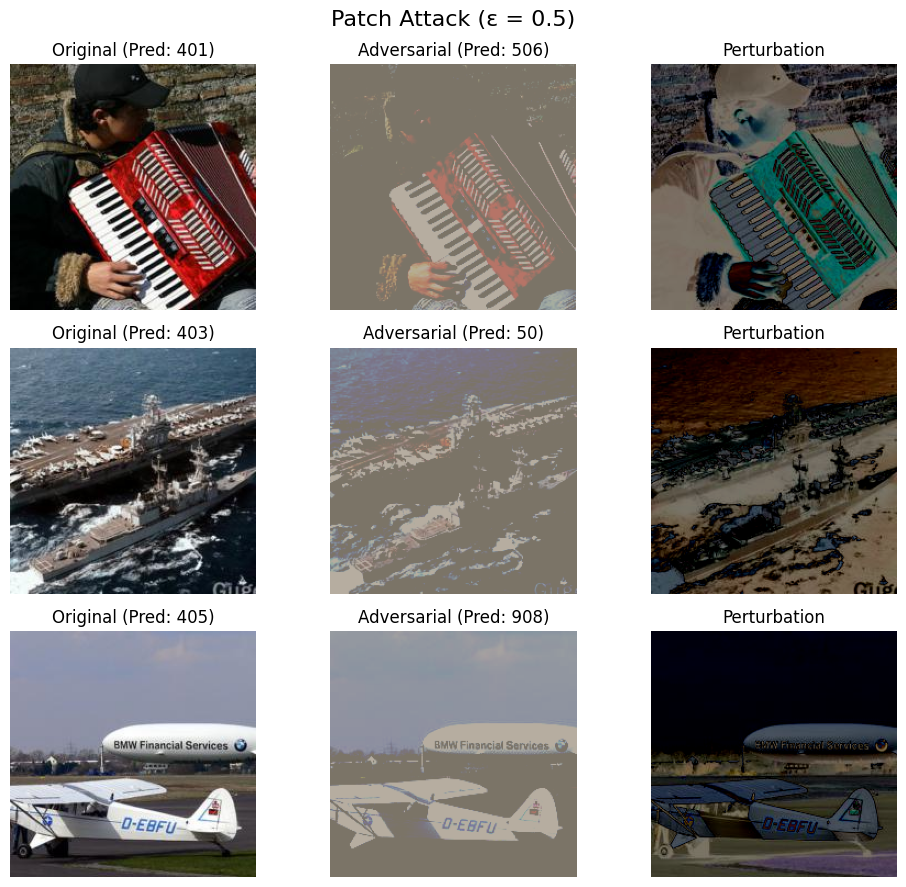

In [23]:
patch_samples = [adv_imgs3[i] for i in sample_ids]
visualize_examples(original_samples, patch_samples, "Patch Attack (ε = 0.5)")
